# Module Imports

In [63]:
# Data Reading
# Visualization of data (Word Clouds, N-grams, WordCount trend)
# Preprocessing techniques (Print Headings,use TQDM, example at each)
    # to Lowercase
    # to Alphanumeric
    # remove html tags, replace with space
    # remove urls
    # demojify
    # remove punctuations
    # remove blankspaces
    # Spelling correction(textBlob, distilbert)
    # remove stopwords
    # lemmatization
# 3 vectorizers->save processed data
    # BagOfWords, CountVectorizer
    # TFIDF
    # DistilBert
# model code in seperate cells, freeze and save models
# run each model on all vectorizers
# Evaluation Graphs, Summary Table
# Demo test samples
# Presentation

# !pip install wordcloud
# !pip install --upgrade pillow
# !pip install tokenizers
# !pip install transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
import transformers

# import nltk
# from sklearn.feature_extraction.text import CountVectorizer
# from nltk.corpus import stopwords
# from wordcloud import WordCloud,STOPWORDS
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize
# from bs4 import BeautifulSoup
# import re,string,unicodedata
# from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
# from sklearn.model_selection import train_test_split
# from string import punctuation
# from nltk import pos_tag
# from nltk.corpus import wordnet


import keras
import tensorflow as tf
# import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
# import torch
# import transformers

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vpeddir2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vpeddir2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vpeddir2\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vpeddir2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vpeddir2\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Explore Dataset 

In [2]:
df=pd.read_csv('data/imdb-dataset.csv', on_bad_lines='skip')
df.head()

,review,sentiment
0,https://www.google.com/search?q=df+ ?? cats an...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


positive    25000
negative    25000
Name: sentiment, dtype: int64


C:\Users\vpeddir2\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


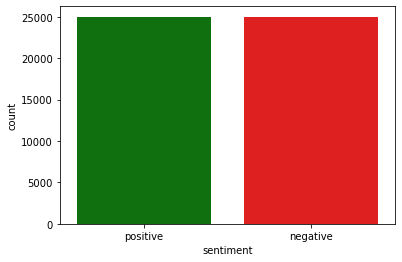

In [4]:
sns.countplot(df.sentiment, palette = ["green","red"])
print(df.sentiment.value_counts())

# Cleaning & Preprocessing

In [27]:
# to Lowercase
    # to Alphanumeric
    # remove html tags, replace with space
    # remove urls
    # demojify
    # remove all non lowercase, spaces
    # remove blankspaces
    # Spelling correction(textBlob, distilbert)
    # remove stopwords
    # lemmatization
df=pd.read_csv('data/imdb-dataset.csv', on_bad_lines='skip')
print(df.review[0])
POSITIVE_LABEL = 'positive'
NEGATIVE_LABEL = 'negative'

url = "https://raw.githubusercontent.com/MFuchs1989/Datasets-and-Miscellaneous/main/datasets/NLP/Text%20Pre-Processing%20VII%20(Special%20Cases)/chat_expressions.csv" 
chat_expressions = pd.read_csv(url, on_bad_lines='skip')
chat_words = dict(zip(chat_expressions.Chat_Words, chat_expressions.Chat_Words_Extended))

lm = WordNetLemmatizer()
pos_dict = {'A': wordnet.ADJ, 'N': wordnet.NOUN, 'R': wordnet.ADV, 'V': wordnet.VERB}
stop_words = stopwords.words('english')
stop_words.remove('not')

# print('\nstopwords = ', stop_words)

def verify_labels(data):
    for i, d in enumerate(data):
        if d[1] != POSITIVE_LABEL and d[1] != NEGATIVE_LABEL:
                raise Exception(d[1])
        yield d

def labels_to_bools(data):
    print("\nConvert Labels to Bools...")
    for d in data:
        d[1] = 1 if d[1] == POSITIVE_LABEL else 0
        yield d

def to_lowercase(data):
    print("\nConvert to Lowercase...")
    for d in data:
        d[0] = d[0].lower()
        yield d
        
def remove_html_tags(data):
    print("\nRemoving HTML Tags...")
    for d in data:
        d[0] = d[0].replace('<br /><br />', ' ').replace('\x85', ' ').replace('\x96', ' ')
        yield d

def expand_contractions(data):
    print("\nExpanding Contractions...")
    for d in data:
        d[0] = d[0].replace('n\'t', ' not').replace('\'ve', ' have').replace('\'ll', ' will').replace('\'em', ' them')
        yield d
        
def remove_urls(data):
    print("\nRemoving URL's ...")
    for d in data:
        pattern = re.compile(r'https?://\S+|www\.\S+')
        d[0]=pattern.sub(r'', d[0])
        yield d
        
def demojize(data):
    for d in data:
        d[0]=emoji.demojize(d[0])
        yield d

def convert_chat_words(data):
    print("\nStarting Chatword Conversion...")
    for d in data:
        new_text = []
        for w in d[0].split():
            if w.upper() in chat_words:
                new_text.append(chat_words[w.upper()])
            else:
                new_text.append(w)
        d[0] = " ".join(new_text)        
        yield d

def remove_stopwords_and_lemmatize(data):
    print("\nStarting stopword removal and lemmatization...")
    for d in tqdm(data):
        updated_pos = []
        sentence = ''
        pos_text = pos_tag(word_tokenize(d[0]))

        for word, tag in pos_text:
            if word.lower() not in stop_words:
                updated_pos.append((word, pos_dict.get(tag[0].upper(), wordnet.NOUN)))

        for word, tag in updated_pos:
            if not tag:
                sentence += ' ' + word
            else:
                sentence += ' ' + lm.lemmatize(word, tag)

        d[0] = sentence.strip()
        yield d
        
def remove_all_special_chars(data):
    for d in data:
        d[0] = re.sub(r'\s[a-z]\s', ' ', re.sub('[^a-z\s]', '', d[0]))
        yield d
        
def compose(fns, data):
    if len(fns) == 1:
        return fns[0](data)
    return compose(fns[1:], fns[0](data))


def preprocess_data(data):
    processors = [
        verify_labels,
        labels_to_bools,
        expand_contractions,
        convert_chat_words,
        to_lowercase,
        remove_html_tags,
        remove_urls,
        remove_stopwords_and_lemmatize,
        remove_all_special_chars
        #demojize,
    ]
    return tuple(row for row in compose(processors, data))


preprocess_data(df.to_numpy()[0:5])
print("\n",df.review[0])

https://www.google.com/search?q=df+ ?? cats and dogs One LOL of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />


0it [00:00, ?it/s]


Removing URL's ...

Removing HTML Tags...

Convert to Lowercase...

Starting Chatword Conversion...

Expanding Contractions...

Convert Labels to Bools...



5it [00:00, 94.27it/s]


   cat dog one laugh loud reviewer mention watch  oz episode hook  right  exactly happen  first thing strike oz brutality unflinching scene violence  set right word go  trust  not show faint hearted timid  show pull punch regard drug  sex violence  hardcore  classic use word  call oz nickname give oswald maximum security state penitentary  focus mainly emerald city  experimental section prison cell glass front face inwards  privacy not high agenda  em city home many  aryan  muslim  gangsta  latino  christian  italian  irish  scuffle  death stare  dodgy dealing shady agreement never far away  would say main appeal show due fact go show would not dare  forget pretty picture paint mainstream audience  forget charm  forget romance  oz not mess around  first episode ever saw strike nasty surreal  could not say ready  watch  develop taste oz  get accustom high level graphic violence  not violence  injustice  crooked guard sell nickel  inmate kill order get away  well mannered  middle class 

# Visual Analysis

25000


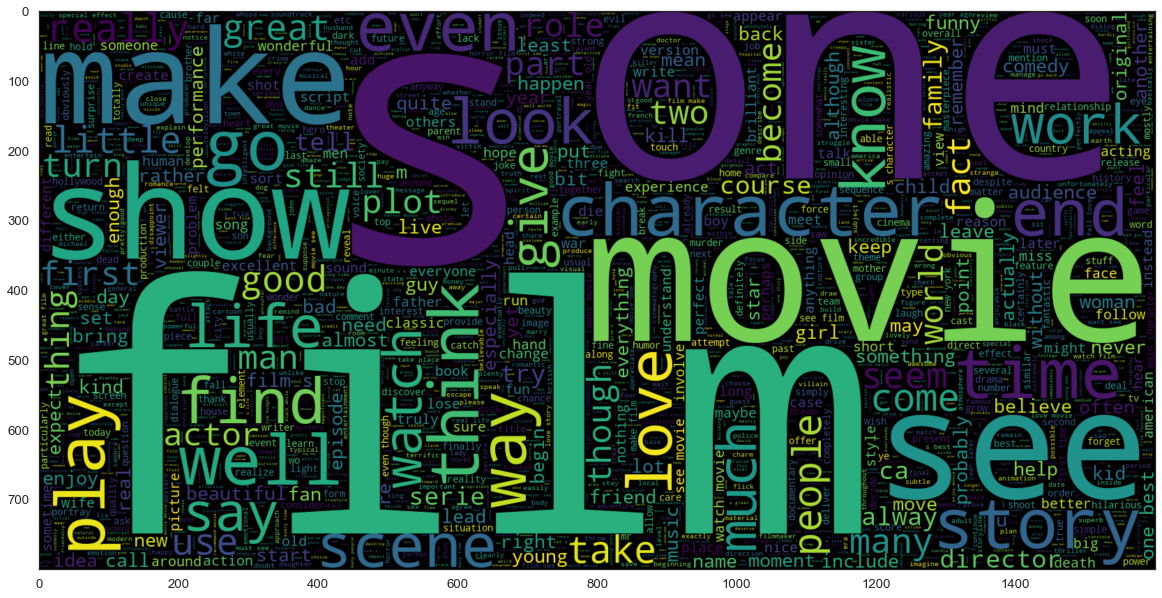

In [20]:
df = pd.read_csv('processed_data.csv')
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')
print(len(df[df.sentiment == 1]))

                                                  review sentiment
3      basically s family little boy  jake  think s z...         0
7      show amazing  fresh  innovative idea  s first ...         0
8      encourage positive comment film look forward w...         0
10     phil alien one quirky film humour base around ...         0
11     saw movie  come  recall scariest scene big bir...         0
...                                                  ...       ...
49994  typical junk comedy  almost laugh  genuine mom...         0
49996  bad plot  bad dialogue  bad acting  idiotic di...         0
49997  catholic taught parochial elementary school nu...         0
49998  m go disagree previous comment side maltin one...         0
49999  one expect star trek movie high art  fan expec...         0

[25000 rows x 2 columns]


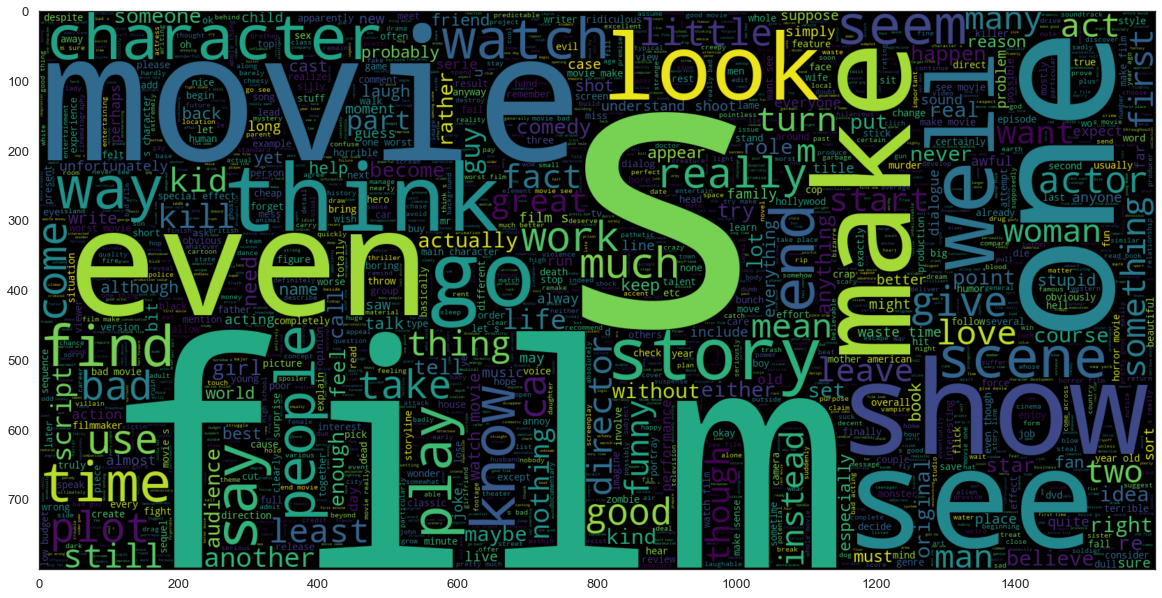

In [21]:
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')
print(df[df.sentiment == 0])

In [22]:
print(df[df.sentiment == 1])

                                                  review sentiment
0        cat dog one laugh loud reviewer mention watc...         1
1      wonderful little production  filming technique...         1
2      think wonderful way spend time hot summer week...         1
4      petter mattei s  love time money  visually stu...         1
5      probably alltime favorite movie  story selfles...         1
...                                                  ...       ...
49983  love  fan original series  always wonder back ...         1
49985  imaginary hero clearly best film year  complet...         1
49989  get one week ago love  s modern  light filled ...         1
49992  john garfield play marine blind grenade fight ...         1
49995  think movie right good job  not creative origi...         1

[25000 rows x 2 columns]


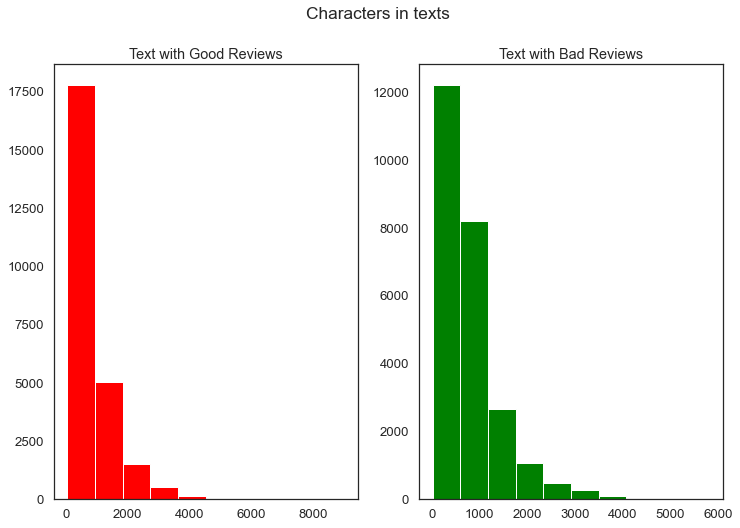

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['sentiment']==1]['review'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Text with Good Reviews')
text_len=df[df['sentiment']==0]['review'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Characters in texts')
plt.show()

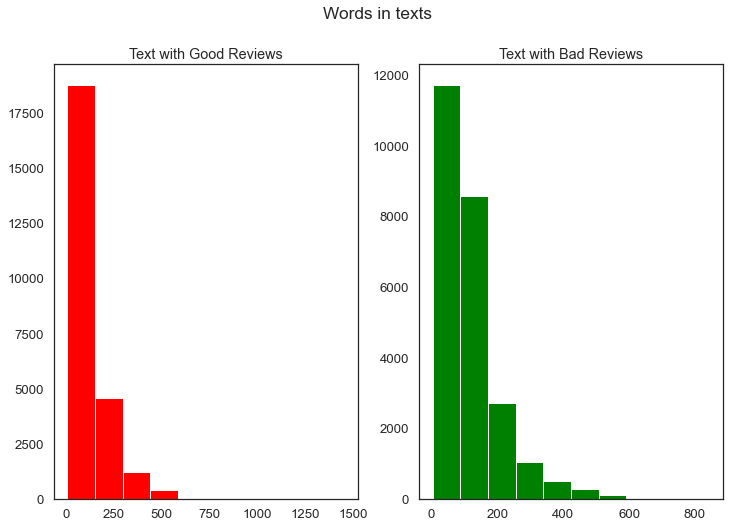

In [24]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['sentiment']==1]['review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Text with Good Reviews')
text_len=df[df['sentiment']==0]['review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Words in texts')
plt.show()

In [26]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.review)
corpus[:5]

from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'not': 128620,
 's': 124572,
 'movie': 101661,
 'film': 93925,
 'one': 54097,
 'make': 43569,
 'like': 43223,
 'see': 41182,
 'get': 35638,
 'time': 30534}

In [33]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
df = pd.read_csv('processed_data.csv')
most_common_uni = get_top_text_ngrams(df.review,20,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [34]:
most_common_bi = get_top_text_ngrams(df.review,20,2)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Bigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [35]:
most_common_tri = get_top_text_ngrams(df.review,20,3)
most_common_tri = dict(most_common_tri)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_tri.keys())
temp["Count"] = list(most_common_tri.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Trigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

# Vectorization

In [43]:
import random
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

class TextDataVectorizer:
    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.vectorizer = None

    def label_encode(self, y):
        labels = self.label_encoder.fit_transform(y.values)
        return labels

    def count_vectorize(self, X):
        self.vectorizer = CountVectorizer()
        X_vectorized = self.vectorizer.fit_transform(X)
        return X_vectorized

    def tfidf_vectorize(self, X):
        self.vectorizer = TfidfVectorizer()
        X_vectorized = self.vectorizer.fit_transform(X)
        return X_vectorized
    
class LSTMVectorizer:
    """Vectorize reviews in two ways.

    The first method is a simple key-based approach, where a 1-to-1 mapping of words to
    numbers is created. The numbers have no meaning beyond identifying a particular
    word.

    The second method calculates a "sentiment score" for each based on the number of 
    positive and negative reviews it appears in. The words are then ranked by score
    and their ordering is used as their indexes.
    """
    
    SIMPLE_KEY_VECTORIZER = 'simple-key'
    ORDERED_SENTIMENT_VECTORIZER = 'ordered-sentiment'

    def __init__(self, data):
        self.data = data

    def vectorize(self, space_type):
        to_vectors = self.choose_vectorizer(space_type)
        return to_vectors(self.data)


    def choose_vectorizer(self, space_type):
        if space_type == LSTMVectorizer.ORDERED_SENTIMENT_VECTORIZER:
            return self.to_ordered_sentiment_indexes
        else:
            return self.to_key_number_vectors


    def to_ordered_sentiment_indexes(self, labeled_reviews):
        counts_by_word = self.count_word_frequencies(labeled_reviews)
        words_to_key = self.to_keys_by_word(counts_by_word)
        vectorized_data = tuple((tuple(words_to_key[word] for word in review[0]), review[1]) for review in labeled_reviews)
        training_data, test_data = self.split_data(vectorized_data)
        return training_data, test_data, len(words_to_key)


    def count_word_frequencies(self, labeled_reviews):
        result = {}
        for review in labeled_reviews:
            for word in review[0]:
                if word not in result:
                    result[word] = np.array([0, 0], dtype=np.int32)
                if review[1]:
                    result[word][0] += 1
                else:
                    result[word][1] += 1
        return result

    def to_keys_by_word(counts_by_word):
        scores_by_word = {}
        for word in counts_by_word:
            counts = counts_by_word[word]
            scores_by_word[word] = counts[0]-counts[1] / (counts[0]+counts[1])
        scores_ordered = OrderedDict(sorted(scores_by_word.items(), key=lambda x: x[1]))
        return {word: i+1 for i, word in enumerate(scores_ordered)}

    def to_key_number_vectors(self, labeled_reviews):
        all_words = set(word for review in labeled_reviews for word in review[0])
        words_to_key = {word: i + 1 for i, word in enumerate(all_words)}
        vectorized_data = tuple((tuple(words_to_key[word] for word in review[0]), review[1]) for review in labeled_reviews)
        training_data, test_data = self.split_data(vectorized_data)
        return training_data, test_data, len(all_words)

    def split_data(self, all_data):
        cutoff = len(all_data) // 2
        data = random.sample(all_data, len(all_data))
        return [data[:cutoff], data[cutoff:]]

In [54]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df.review,df.sentiment,random_state = 0 , stratify = df.sentiment)

# DistilBert

In [46]:
from tokenizers import BertWordPieceTokenizer
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [56]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

# Example usage
x_train = fast_encode(x_train.values, fast_tokenizer, maxlen=400)
x_test = fast_encode(x_test.values, fast_tokenizer, maxlen=400)


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [58]:
def build_model(transformer, max_len=400):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [64]:
model = build_model(bert_model, max_len=400)
model.summary()
history = model.fit(x_train,y_train,batch_size = 32 ,validation_data=(x_test,y_test),epochs = 3)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 400)]            0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 400,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem_1   (None, 768)              0         
 (SlicingOpLambda)                                               
                                                                 
 dense_1 (Dense)             (None, 1)                 769       
                                                             

C:\Users\vpeddir2\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



KeyboardInterrupt: 

# LSTM

In [ ]:
import time
import csv
import gzip
import itertools
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

class LSTMSentimentClassifier:

    NUM_EMBEDDING_DIMENSIONS = 50
    NUM_HIDDEN_DIMENSIONS = 128
    NUM_OUTPUT_DIMENSIONS = 1
    BATCH_SIZE = 32
    NUM_EPOCHS = 50

    def __init__(self, train_data, test_data, vocab_size, padding_element=0.0):
        self.padding_element = padding_element
        self.train_dataset = MovieReviewsDataset(train_data)
        self.train_loader = DataLoader(self.train_dataset, batch_size=LSTMSentimentClassifier.BATCH_SIZE, shuffle=True,
                                       collate_fn=self.collate_fn)
        self.test_dataset = MovieReviewsDataset(test_data)
        self.test_loader = DataLoader(self.test_dataset, batch_size=LSTMSentimentClassifier.BATCH_SIZE, shuffle=False,
                                      collate_fn=self.collate_fn)
        self.lstm = SentimentLSTM(vocab_size, embedding_dim=LSTMSentimentClassifier.NUM_EMBEDDING_DIMENSIONS, hidden_dim=LSTMSentimentClassifier.NUM_HIDDEN_DIMENSIONS,
                                  output_dim=LSTMSentimentClassifier.NUM_OUTPUT_DIMENSIONS)
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.lstm.parameters())

    def collate_fn(self, batch):
        reviews, labels = zip(*batch)
        reviews_padded = pad_sequence(reviews, batch_first=True, padding_value=0.0)
        labels = torch.tensor(labels, dtype=torch.float)
        return reviews_padded, labels

    def train_and_evaluate(self):
        for epoch in range(LSTMSentimentClassifier.NUM_EPOCHS):
            print('Starting epoch ' + str(epoch + 1))
            start = time.perf_counter()
            self.train()
            avg_val_loss, avg_val_accuracy = self.evaluate()
            print(f"Epoch: {epoch + 1}, Validation loss: {avg_val_loss}, Validation accuracy: {avg_val_accuracy}",
                  str(time.perf_counter() - start) + 's')

    def train(self):
        self.lstm.train()
        for inputs, labels in self.train_loader:
            self.optimizer.zero_grad()
            outputs = self.lstm(inputs)
            loss = self.criterion(outputs.squeeze(), labels)
            loss.backward()
            self.optimizer.step()

    def evaluate(self):
        self.lstm.eval()
        total_eval_loss = 0
        total_eval_accuracy = 0
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                outputs = self.lstm(inputs)
                loss = self.criterion(outputs.squeeze(), labels)
                total_eval_loss += loss.item()
                preds = torch.round(torch.sigmoid(outputs.squeeze()))
                total_eval_accuracy += torch.sum(preds == labels).item()

        avg_val_loss = total_eval_loss / len(self.test_loader)
        avg_val_accuracy = total_eval_accuracy / len(self.test_dataset)
        return avg_val_loss, avg_val_accuracy


class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=1):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size + 1, embedding_dim=embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(x)
        return self.output_layer(hidden[-1])


class MovieReviewsDataset(Dataset):
    def __init__(self, reviews):
        self.reviews = [torch.tensor(np.array(review[0]), dtype=torch.long) for review in reviews]
        self.labels = torch.tensor([review[1] for review in reviews], dtype=torch.float)

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return self.reviews[idx], self.labels[idx]
    
def run_lstm_classifiers():
    for vector_type in [LSTMVectorizer.SIMPLE_KEY_VECTORIZER, LSTMVectorizer.ORDERED_SENTIMENT_VECTORIZER]:
        print(f"Running {vector_type}-based LSTM classifier.")
        start = time.perf_counter()
        classifier = LSTMVectorizer(data=preprocess_data(read_csv(yield_all_data_lines())))
        train_data, test_data, size = classifier.vectorize(space_type=vector_type)
        classifier = LSTMSentimentClassifier(train_data, test_data, size)
        classifier.train_and_evaluate()
        print(time.perf_counter() - start)


def yield_all_data_lines():
    with gzip.open('./data/imdb-dataset.csv.gz', mode='rt', encoding='utf-8') as file:
        for line in file:
            yield line


def read_csv(lines, num_of_records):
    reader = csv.reader(line for line in lines)
    if num_of_records > 0:
        return itertools.islice((row for row in reader), num_of_records)
    else:
        return (row for row in reader)
